# Regularized FAVAR -> FAFEVD
## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
sys.path.append('../../kungfu/')

In [66]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from src.net import ElasticNet # glmnet estimator
from src.favar import FAVAR
import networkx as nx

from sklearn.model_selection import GridSearchCV

import datetime as dt

#import statsmodels.api as sm
#import statsmodels.formula.api as smf
#import linearmodels as lm

In [67]:
import src
import kungfu as kf

## Load data

In [68]:
df_desc = src.loader.load_descriptive()

In [69]:
# inputs
year = 2004
selected_factors=['mktrf']

In [70]:
# load year data & select factors
df_est, df_ana, df_factors_est, df_factors_ana = src.loader.load_year_all(year)
fac_est, fac_ana = src.loader.select_factor_data(df_factors_est, df_factors_ana, selected_factors=selected_factors)

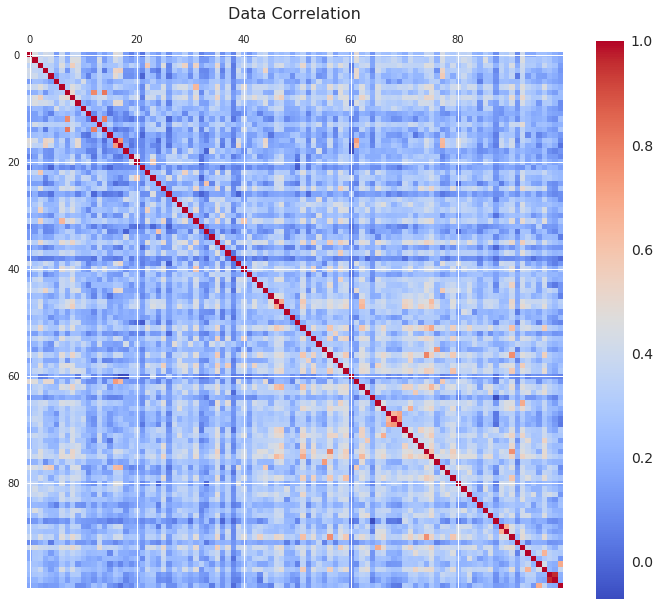

In [71]:
src.plot.corr_heatmap(df_est.corr(), 'Data Correlation')

In [36]:
favar.fit_elastic_net(alpha=0, lambdau=0, penalty_weights=_.penalty_weights(method='ElasticNet', alpha=0, lambdau=1e-7))

In [37]:
t_periods, n_series, k_factors = src.favar.data_dimensions(df_est, fac_est)
y, X = src.favar.build_matrices(df_est, fac_est, lag=1)

## Estimate

### Stage 1:  FAVAR
$r_{i,t} = \alpha_i + \sum_{k=1}^{K} \beta_{i,k} f_{k,t} + \sum_{j=1}^{N} \gamma_{i,j} r_{j,t-1}  + u_{i,t}$

where
- $r_{i,t}$: $1 \times 1$ (asset excess returns)
- $\alpha_i$: $1 \times 1$ (intercepts/pricing errors)
- $f_{k,t}$: $1 \times 1$ (factor excess returns)
- $\beta_{i,k}$: $1 \times 1$ (factor loadings)
- $\gamma_{i,j}$: $1 \times 1$ (VAR coefficients)
- $u_{i,t}$: $1 \times 1$ (error term)

Adaptive Elastic Net with hyperparameters $\lambda, \kappa$

$(\hat{\alpha}, \hat{\beta}, \hat{\gamma})= \underset{(\alpha, \beta, \gamma)}{argmin} \Bigg[ \frac{1}{2NT}\sum_{i=1}^{N}\sum_{t=1}^{T} \Big(r_{i,t} - \big(\alpha_i + \sum_{k=1}^{K} \beta_{i,k} f_{k,t} + \sum_{j=1}^{N} \gamma_{i,j} r_{j,t-1}\big)\Big)^2 + \lambda \sum_{i=1}^{N}\sum_{j=1}^{N} w_{i,j} \big(\kappa |\gamma_{i,j}| + (1-\kappa) \frac{1}{2} \gamma_{i,j}^2\big)\Bigg]$

weights are set to $w_{i,j} =|\hat{\beta}_{i,j,OLS}|^{-1}$

In [79]:
favar = FAVAR(df_est, fac_est, p_lags=1)

In [80]:
hyperparameter_grid = {'alpha': [0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 1],
                           'lambdau': np.linspace(1e-8, 1e-5, 15),
                           }

In [ ]:
favar.fit_elastic_net_cv(hyperparameter_grid)

Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.5s


In [49]:
def fit_favar_cv(favar):
    # model & data
    elnet = ElasticNet(intercept=False, standardize=False, threshold=1e-4)
    X, y = favar._build_X_y()
    penalty_weights = favar.penalty_weights(method='OLS', alpha=0, lambdau=1e-7)
    
    # cv parameters
    hyperparameter_grid = {'alpha': [0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 1],
                           'lambdau': np.linspace(1e-8, 1e-5, 15),
                           }
    split = favar.make_cv_splitter(splits=10)
    cv = GridSearchCV(elnet, hyperparameter_grid, cv=split, n_jobs=-1, verbose=1)
    
    # fit 
    cv = cv.fit(X, y, penalty_weights=penalty_weights)
    return (cv, penalty_weights)

In [51]:
cv, penalty_weights = src.utils.fit_favar_cv(favar)

Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  5.4min finished


In [58]:
favar.fit_elastic_net(alpha=cv.best_params_['alpha'], lambdau=cv.best_params_['lambdau'], penalty_weights=penalty_weights)
favar.var_1_matrix

array([[-0.06796251,  0.        ,  0.        , ..., -0.01010921,
        -0.05260009,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.00203312],
       [ 0.02473408,  0.        , -0.03915135, ...,  0.01168812,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.03310128,  0.04201497, ...,  0.        ,
         0.00567702,  0.01106425],
       [ 0.00527873,  0.02291284,  0.01682373, ...,  0.03119104,
         0.00185499,  0.01756334],
       [ 0.        , -0.08755661,  0.01781987, ...,  0.        ,
        -0.00650088, -0.13122606]])

In [13]:
# set up model & cross validation
elnet = ElasticNet(intercept=False, standardize=False, threshold=1e-4)
hyperparameter_grid = {'alpha': [0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 1],
                       'lambdau': np.linspace(1e-8, 1e-5, 15),
                      }
split = src.utils.make_cv_splitter(n_splits=10, n_series=n_series, t_periods=t_periods)
cv = GridSearchCV(elnet, hyperparameter_grid, cv=split, n_jobs=-1, verbose=1)

In [14]:
%%time

# estimation
penalty_weights = src.favar.ols_penalty_weights(X, y, n_series=n_series, k_factors=k_factors, has_intercepts=True)
cv = cv.fit(X, y, penalty_weights=penalty_weights)

Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  5.6min finished


CPU times: user 12.1 s, sys: 4.14 s, total: 16.2 s
Wall time: 5min 38s


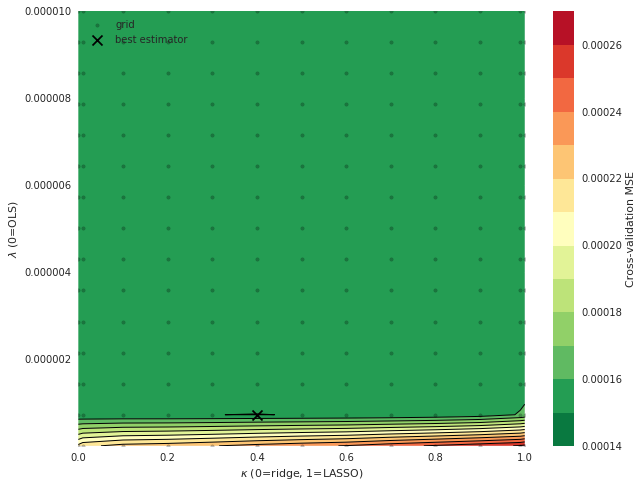

In [54]:
src.plot.cv_contour(cv, 12)

In [55]:
coefficients = cv.best_estimator_.coef_
(alphas, betas, gammas) = src.favar.format_coefficients(coefficients, 1, n_series)
print('VAR(1) matrix is {}% dense.'.format((gammas!=0).sum()/n_series**2*n_series))
print('Best hyperparameters are alpha={}, lambda={}.'.format(cv.best_params_['alpha'], cv.best_params_['lambdau']))

VAR(1) matrix is 49.79% dense.
Best hyperparameters are alpha=0.4, lambda=7.235714285714286e-07.


### Stage 2: Covariances

In [75]:
residuals = src.favar.residual_matrix(y, X, coefficients, n_series)

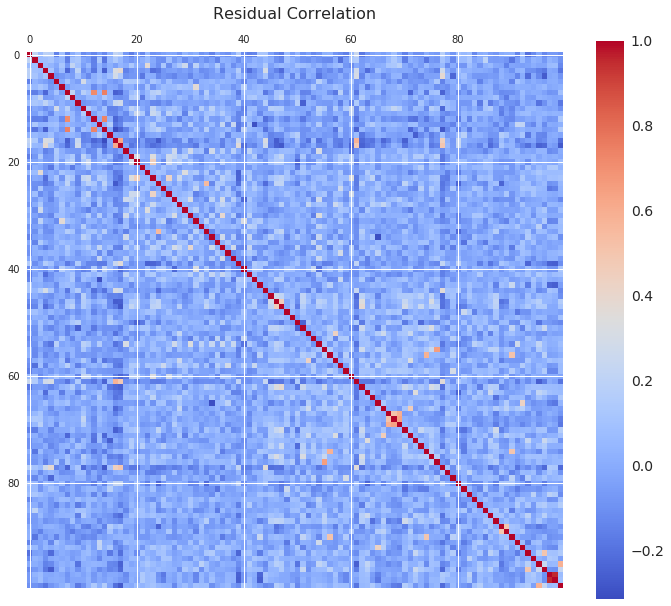

In [76]:
src.plot.corr_heatmap(pd.DataFrame(residuals).corr(), 'Residual Correlation')

In [24]:
from sklearn.covariance import LedoitWolf, GraphicalLassoCV, EmpiricalCovariance, OAS

In [25]:
%%time
emp = EmpiricalCovariance().fit(residuals)
emp_cov = np.array(emp.covariance_)

CPU times: user 31.2 ms, sys: 62.5 ms, total: 93.8 ms
Wall time: 144 ms


In [26]:
%%time
lw = LedoitWolf().fit(residuals)
lw_cov = np.array(lw.covariance_)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.52 ms


In [27]:
%%time
oas = OAS().fit(residuals)
oas_cov = np.array(oas.covariance_)

CPU times: user 31.2 ms, sys: 0 ns, total: 31.2 ms
Wall time: 7 ms


In [28]:
%%time
glasso = GraphicalLassoCV().fit(residuals)
glasso_cov = np.array(glasso.covariance_)

CPU times: user 37.9 s, sys: 17.3 s, total: 55.2 s
Wall time: 20.4 s


In [89]:
for ii, cov in enumerate([emp_cov, lw_cov, oas_cov, glasso_cov]):
    print(abs(src.utils.cov_to_corr(cov)).sum())

894.6218490912033
683.2232136542352
722.835444428167
409.1693552758296


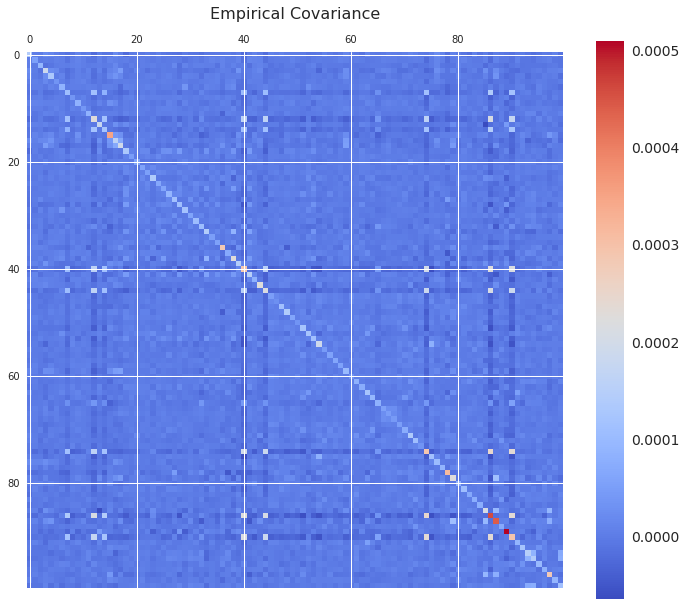

In [30]:
src.plot.plot_corr_heatmap(pd.DataFrame(emp_cov), 'Empirical Covariance')

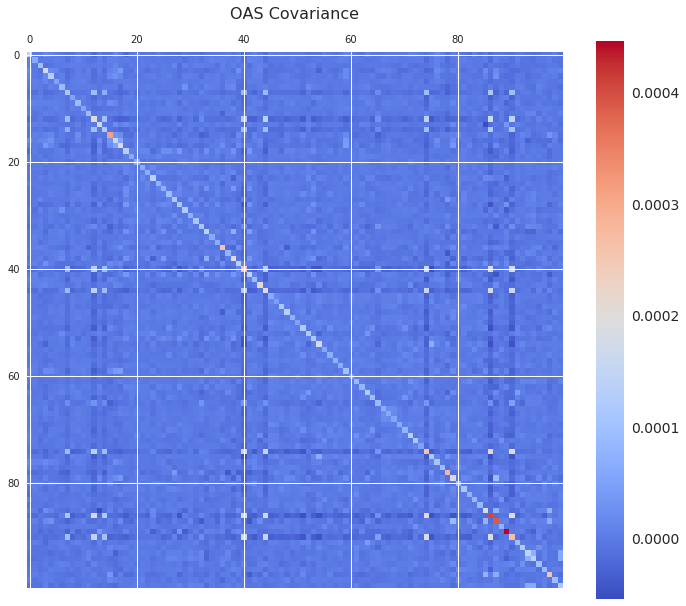

In [31]:
src.plot.plot_corr_heatmap(pd.DataFrame(oas_cov), 'OAS Covariance')

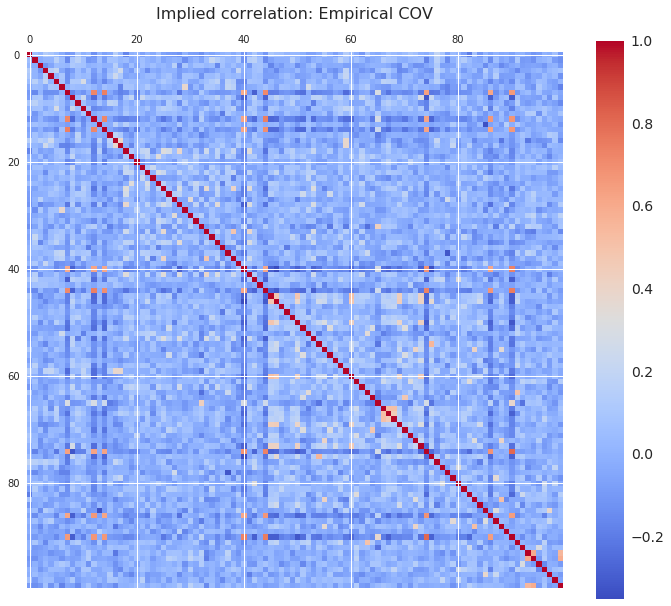

In [32]:
src.plot.plot_corr_heatmap(src.utils.cov_to_corr(emp_cov), 'Implied correlation: Empirical COV')

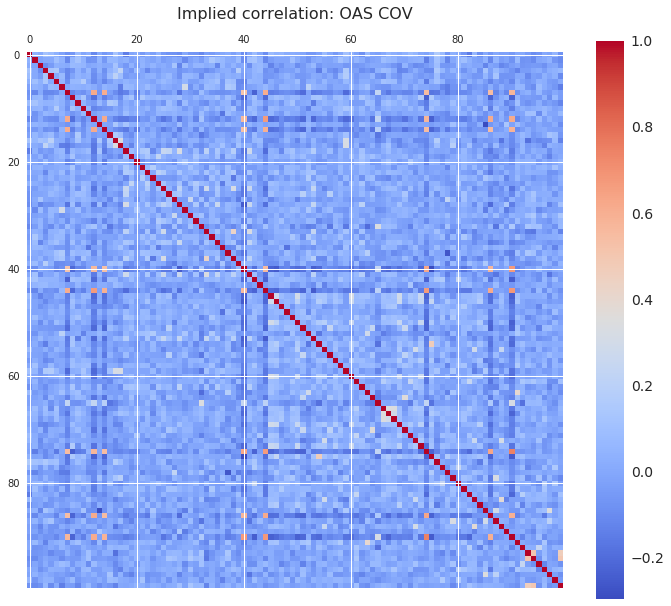

In [33]:
src.plot.plot_corr_heatmap(src.utils.cov_to_corr(oas_cov), 'Implied correlation: OAS COV')

## FEVD

In [34]:
a_1 = gammas
sigma_u = oas_cov

In [35]:
fevd = src.FEVD(a_1, sigma_u)

In [36]:
h = 10

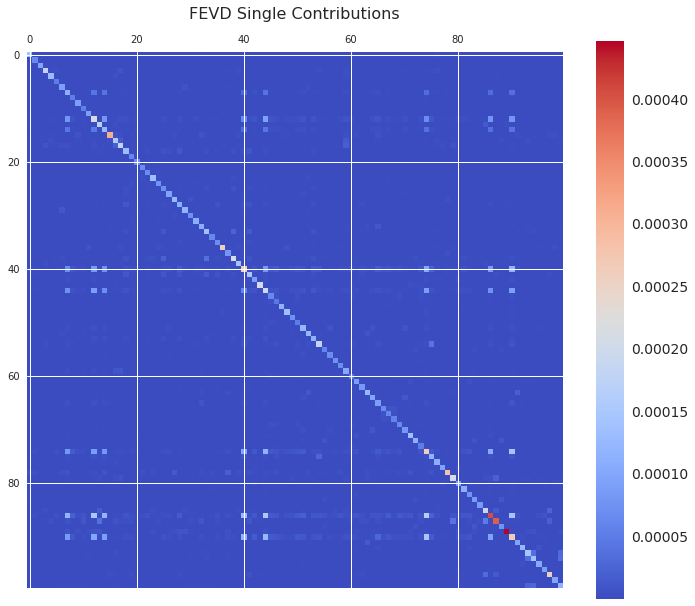

In [37]:
src.plot.plot_corr_heatmap(pd.DataFrame(fevd.fev_single(h)), 'FEVD Single Contributions')

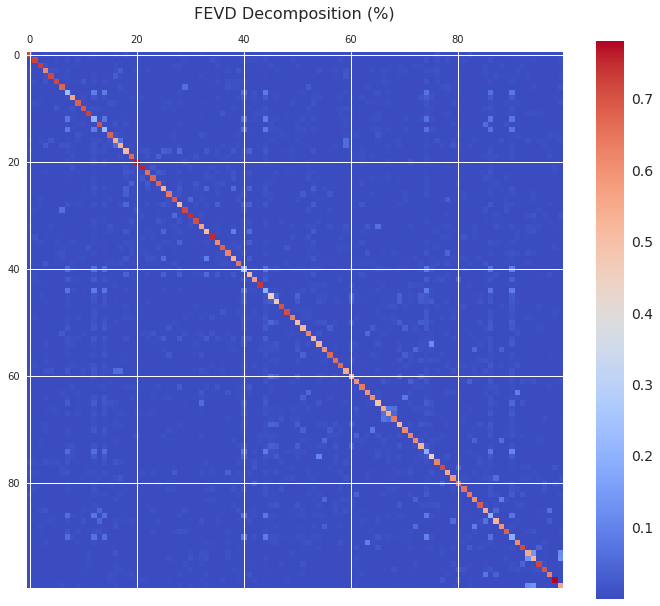

In [38]:
src.plot.plot_corr_heatmap(pd.DataFrame(fevd.decompose_pct(horizon=h)), 'FEVD Decomposition (%)')

In [39]:
np.diag(fevd.decompose_pct(horizon=h)).sum()

58.97503172893115

In [40]:
fevd.in_connectedness(horizon=h).mean()

0.41024968271068846

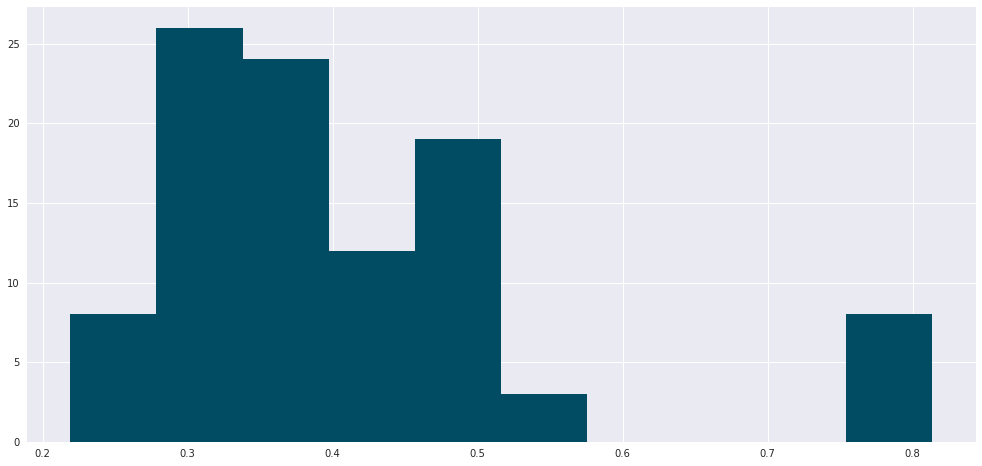

In [41]:
pd.Series(fevd.in_connectedness(horizon=h).ravel()).hist()
plt.show()

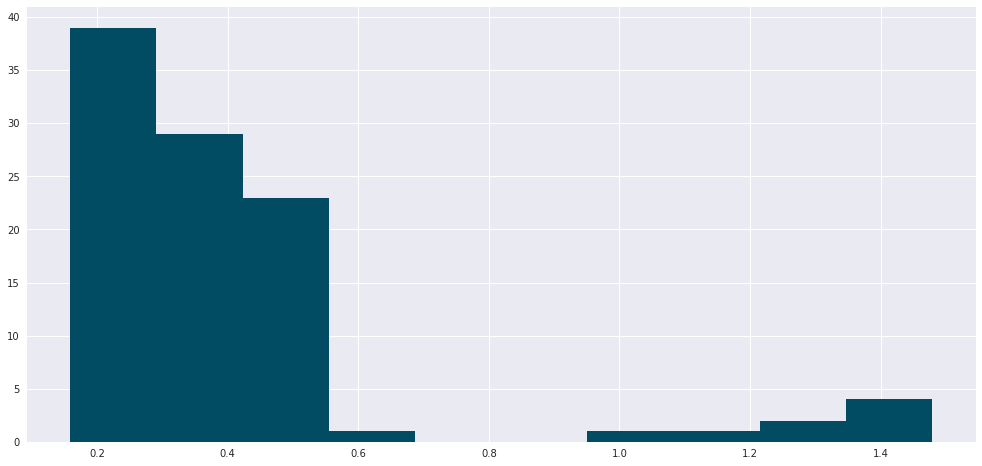

In [42]:
pd.Series(fevd.out_connectedness(horizon=h).ravel()).hist()
plt.show()

In [90]:
fevd.average_connectedness(h)

0.41024968271068846

In [43]:
fevd_10 = fevd.summarize(10)

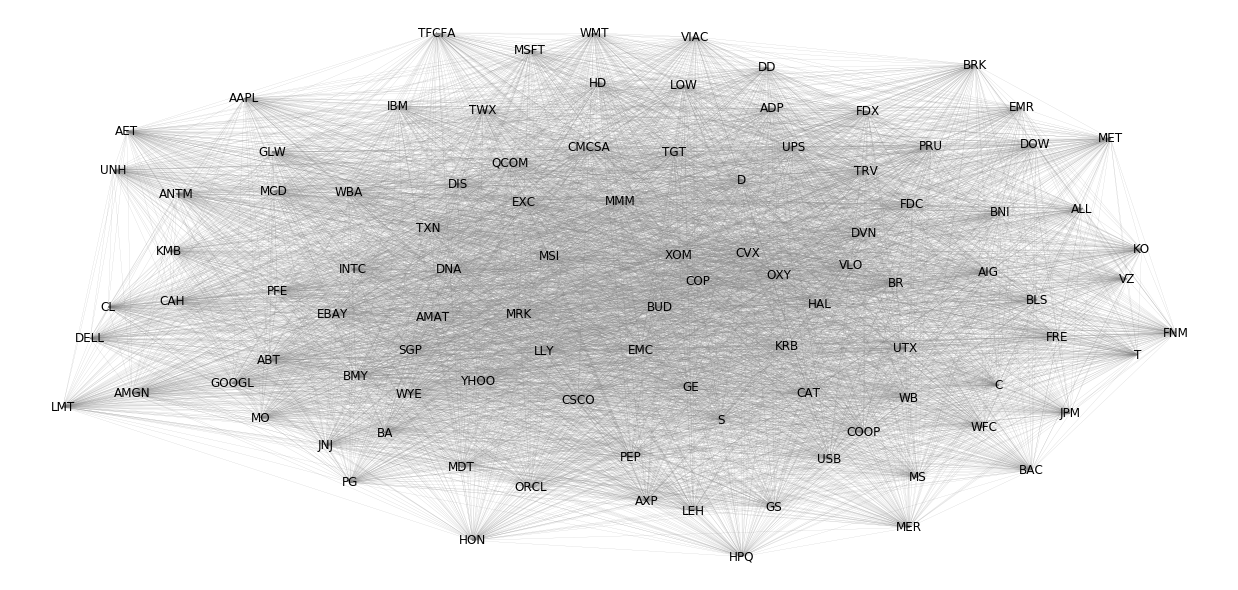

In [107]:
graph = fevd.to_graph(1)
column_to_ticker = src.utils.map_column_to_ticker(estimation_data, df_crsp_desc)
src.plot.plot_network_graph(graph, column_to_ticker)
#nx.eigenvector_centrality(graph)

## Analysis

In [602]:
df_measures = pd.DataFrame([])
df_measures['mean_est_ret'] = estimation_data.mean()*252
df_measures['mean_ana_ret'] = analysis_data.mean()*252
df_measures['beta'] = betas
df_measures['alpha'] = alphas
df_measures['in_connectedness'] = fevd.in_connectedness(horizon=h)
df_measures['out_connectedness'] = fevd.out_connectedness(horizon=h)
df_measures['fev_others'] = fevd.fev_others(horizon=h)
df_measures['fev_all'] = fevd.fev_all(horizon=h)
df_measures['eigenvalue_centrality'] = np.linalg.eig(oas_cov)[1][:,0]
df_measures['average_connectedness'] = fevd.average_connectedness(horizon=h)

df_measures.corr()

,mean_est_ret,mean_ana_ret,beta,alpha,in_connectedness,out_connectedness,fev_others,fev_all,eigenvalue_centrality,average_connectedness
mean_est_ret,1.000000e+00,3.714159e-01,3.666284e-01,8.391304e-01,1.356805e-01,1.672763e-01,2.651275e-01,1.156453e-01,4.772453e-01,-7.932223e-16
mean_ana_ret,3.714159e-01,1.000000e+00,-1.999923e-01,4.384556e-01,-4.370676e-02,-5.992382e-02,-1.093773e-01,-1.045052e-01,2.739620e-01,3.607872e-17
beta,3.666284e-01,-1.999923e-01,1.000000e+00,-1.428982e-01,4.776377e-01,5.038726e-01,6.734133e-01,3.334746e-01,-5.400363e-02,8.275835e-16
alpha,8.391304e-01,4.384556e-01,-1.428982e-01,1.000000e+00,-1.467729e-01,-1.363181e-01,-6.397293e-02,1.592428e-02,5.897582e-01,7.091830e-17
in_connectedness,1.356805e-01,-4.370676e-02,4.776377e-01,-1.467729e-01,1.000000e+00,9.538915e-01,7.289046e-01,-3.312137e-02,-8.214214e-02,-3.430583e-16
out_connectedness,1.672763e-01,-5.992382e-02,5.038726e-01,-1.363181e-01,9.538915e-01,1.000000e+00,7.503229e-01,-4.248771e-02,-1.102243e-01,4.027971e-16
fev_others,2.651275e-01,-1.093773e-01,6.734133e-01,-6.397293e-02,7.289046e-01,7.503229e-01,1.000000e+00,5.730876e-01,1.130951e-01,-3.121117e-16
fev_all,1.156453e-01,-1.045052e-01,3.334746e-01,1.592428e-02,-3.312137e-02,-4.248771e-02,5.730876e-01,1.000000e+00,3.348906e-01,1.934300e-16
eigenvalue_centrality,4.772453e-01,2.739620e-01,-5.400363e-02,5.897582e-01,-8.214214e-02,-1.102243e-01,1.130951e-01,3.348906e-01,1.000000e+00,-3.686825e-17
average_connectedness,-7.932223e-16,3.607872e-17,8.275835e-16,7.091830e-17,-3.430583e-16,4.027971e-16,-3.121117e-16,1.934300e-16,-3.686825e-17,1.000000e+00


In [603]:
kf.FinancialDataFrame(df_measures) \
    .fit_linear_regression('mean_est_ret', ['beta', 'alpha', 'in_connectedness', 'fev_others', 'eigenvalue_centrality']) \
    .summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           mean_est_ret   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     359.4
Date:                Thu, 24 Sep 2020   Prob (F-statistic):           1.26e-59
Time:                        16:41:35   Log-Likelihood:                 176.52
No. Observations:                 100   AIC:                            -341.0
Df Residuals:                      94   BIC:                            -325.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0609      0.025     -2.479      0.015      -0.110      -0.012
beta                      0.2218      0.014     16.066      0.000       0.194       0.249
alpha                   226.9824      6.978     32.529      0.000     213.128     240.837
in_connectedness          0.1162      0.050      2.309      0.023       0.016       0.216
fev_others             -139.6113     81.297     -1.717      0.089    -301.028      21.805
eigenvalue_centrality    -0.0641      0.055     -1.157      0.250      -0.174       0.046
==============================================================================
Omnibus:                       10.405   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.848
Skew:                          -0.660   Prob(JB):                      0.00441
Kurtosis:                       3.928   Cond. No.                     2.83e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.83e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [604]:
kf.FinancialDataFrame(df_measures) \
    .fit_linear_regression('mean_ana_ret', ['beta', 'alpha', 'in_connectedness', 'fev_others', 'eigenvalue_centrality']) \
    .summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           mean_ana_ret   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     5.500
Date:                Thu, 24 Sep 2020   Prob (F-statistic):           0.000174
Time:                        16:41:38   Log-Likelihood:                 26.521
No. Observations:                 100   AIC:                            -41.04
Df Residuals:                      94   BIC:                            -25.41
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.1103      0.110     -1.002      0.319      -0.329       0.108
beta                     -0.0690      0.062     -1.115      0.268      -0.192       0.054
alpha                   110.4466     31.273      3.532      0.001      48.354     172.539
in_connectedness          0.2955      0.226      1.310      0.194      -0.152       0.743
fev_others             -278.3844    364.344     -0.764      0.447   -1001.798     445.030
eigenvalue_centrality     0.1229      0.248      0.495      0.622      -0.370       0.616
==============================================================================
Omnibus:                        0.124   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.940   Jarque-Bera (JB):                0.086
Skew:                          -0.067   Prob(JB):                        0.958
Kurtosis:                       2.946   Cond. No.                     2.83e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.83e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""